# EBA Data Ingestion

We need to collect data from two main sources for this project:
 - First is loading the EBA data into the SQL DB
 - Second is getting the real weather data from NOAA based off Weather stations.   
   This is done via FTP using `code/utils/get_weather_data.py` for the relevant time periods.
 - (Third would be accessing NOAA's forecast DB.)

 In all cases we will be loading the data into a Postgres Database for easier querying later.  


# Library Sketch and Table Sketch 

- 560 MB of weather station data
- 2.8GB of Energy data
- 5.0GB of forecast data  (could try to only extract station data)

Energy data x 100 ISOs
- Demand
- Demand Forecast
- Net Generation
    (by source)
- Transfers

Weather x 600 stations
- Temp
- Cloud cover
- Precipitation

Forecast
- Temp (gridded 24 hour forecast) of CONUS.  Probably don't want in DB.
- include file ref.
- Try to find nearest forecast pixel for all airports.

Given we want to think about a whole system forecast, we can live with having a few big tables separated by variable.
Use UTC time variables to allow a common index and forecast.

EBA Table
    - datetime
    - source
    - measure
    - value

EBA-Interchange
   - datetime
   - source
   - dest
   - value

Here source/dest are ISO abbreviations.
Measures are abbreviations for demand / demand forecast / interchange / net generation

AirMeta
   id
   station_name
   callsign
   lat
   long
   region
   city
   state

ISD
   - datetime
   - callsign
   - measure
   - value
   
ISD measures are atmospheric variables like temperature.

It's a simple table structure with a lot of repetition.  The alternative of a lot of columns (e.g. one table per variable, one column per ISO/weather station) is possible.  It just takes more setup, and would be awkward for adding more stations and variables.
The data here isn't too big. 

Could compress the data some and instead of having the strings, just have an id to another table.  Querying will just take more joins.  Lets see how big this ends up on disk.

## Proposed SQL Table Structure - EBA

- Our initial project is focused on the demand forecasting piece.  Let's just focus on the bulk attributes for now, and return later if need be for
 breakdowns by generation type

Some considerations at: https://www.timescale.com/blog/best-practices-for-time-series-data-modeling-narrow-medium-or-wide-table-layout-2/

### Options:
1) 1 table per series (hard to look up) - Reject.

2) 1 table per type (100 ISOs as columns).
    - Demand (Time, PDX, BPA, CAISO, ...)
    - Forecast (Time, PDX, BPA, CAISO, ...)
    - Net Generation (Time, PDX, BPA, CAISO,...)
    - Interchange(Time, P1, P2, Amount)

2a) 1 Table per type with 
    weather
    - (Time, Station, Measure, Value)
    eba
    - (Time, ISO, Measure, value)

    - Way easier to add extra stations/ISOs.  May have heavier queries.
    - Way easier to insert data

3) 1 major table per ISO (around 30 sub-series)
   -  PGE (Time, Demand, Forecast, Net Generation, COL, HYD, ..., PGE-BPA, PGE-PACW)
   -  BPA (Time, Demand, Forecast, Net Generation, COL, HYD, ..., BPA-PGE, PGE-PACW)



Leaning toward approach 3.  Better encapsulates system process.  Allows local time and UTC time
Also leaning towards only including UTC time variations.



- Need all series names (types of data)
- Need all ISOs and transferes.

In [1]:
import pandas as pd

from us_elec.SQL.sqldriver import EBAMeta, ISDMeta, SQLDriver
ebm = EBAMeta()
isdm = ISDMeta()
sqldr = SQLDriver()


In [2]:
!pwd && hostname

/tf
a9334cf55332


# Bulk EBA data import

The EBA data can be downloaded from `https://www.eia.gov/opendata/bulk/EBA.zip`.
As of Mar 6, 2023 it's around 2.8 GB, with around 2800 child series, stored in one JSONLines files.

That's downloaded to data/EBA/20230302.  
For initial quick exploration we you can grep out 'California' and 'Portland' series to 


- grepped out all Portland files and California files for a smaller subset of data to play with while cleaning
up the ETL work
  `grep -r "Portland" EBA.txt > EBA_PDX.txt`
  `grep -r "California" EBA.txt > EBA_CA.txt`
  

- This eats a LOT of ram on it's own for all files.  
- Probably best to ETL one at a time.  Even in dict form it's eating around 20GB of RAM.

In [4]:
from us_elec.util.EBA_util import read_eba_txt
#!cd /tf/data/EBA/EBA20230302 && grep Portland EBA.txt > EBA_PDX.txt
#eba_path = '/tf/data/EBA/EBA20230302'
#fname = f'{eba_path}/EBA_PDX.txt'
#all_data = read_eba_txt(fname)

#for dat in all_data:
    # if 'series_id' in dat.keys():
    #     print(dat['series_id'], dat['name'])
    #     print(len(dat['data']), dat['data'][0:2], dat['data'][-1])
    #     print()
    # else:
    #     print(dat['category_id'], dat['name'], dat['childseries'])

- note that the transfers are not fully aligned for the most recent data?  I suspect some sort of reconciliation procedure
clears that up?  Would need to look into that.  Useful for considering trades.

So we have 4 big categories of data in this thing.  All series are provided with local time and global time variations.

- Demand
- Demand Forecast
- Net Generation
- Net Generation (by source) - Much less data
- Total Interchange
- Interchange with other ISOs

- Around 8 years of data for demand/net generation.
- Around 5 years for generation by source data.
- Hourly resolution 
- Around 100 ISOs  (2850 series, 30 series per ISO, but variable interchanges).
- 60k data points per series at hourly resolution.

### Getting Metadata

### Airports

I think the `merge_air_df` is probably already close to what we want: mapping from id to name/region.


## EBA MetaData


In [ ]:
# extract all the meta series 
#!cd /tf/data/EBA/EBA20230302 && grep childseries EBA.txt > metaseries.txt

In [ ]:
# grep -r category_id EBA.txt > metaseries.txt
#fn = '/tf/data/EBA/EBA20230302/metaseries.txt'
#meta_df = pd.read_json(fn, lines=True)

#ebm.extract_meta_data()
#ebm.save_iso_dict_json()
#ebm.load_iso_dict_json()

In [4]:
# parse the json directly grab names / series_id
eba_meta = ebm.read_metadata()

2847it [02:06, 22.45it/s]


In [6]:
# get the sources and tag abbreviations
series_bits = [ebm.parse_eba_series_id(x[1]) for x in eba_meta]

sources = set(x[0] for x in series_bits)
tags = set(tuple(x[2]) for x in series_bits)

In [7]:
len(sources)

82

In [8]:
# verify that all dicts acquired another way are present in the full parse.
iso_map = ebm.load_iso_dict_json()
sources == set(iso_map.keys())

eba_meta - check all isos and types present.

In [11]:
tags

{('D',),
 ('DF',),
 ('ID',),
 ('NG',),
 ('NG', 'COL'),
 ('NG', 'NG'),
 ('NG', 'NUC'),
 ('NG', 'OIL'),
 ('NG', 'OTH'),
 ('NG', 'SUN'),
 ('NG', 'WAT'),
 ('NG', 'WND'),
 ('TI',)}

### Saving Airport Metadata

From `airport_play.ipynb` which downloaded all that data we have the merge_df which merged city and location information
with callsign info.


In [95]:
#df = isdm.get_air_meta_df()
#isdm.save_callsigns()
#isdm.load_callsigns()

## Creating Tables

Now to create the actual tables.  

In [12]:
#ebm.drop_tables(execute=True)
#isdm.drop_tables(execute=True)

DROP TABLE IF EXISTS eba;
DROP TABLE IF EXISTS eba;
DROP TABLE IF EXISTS eba_interchange;
DROP TABLE IF EXISTS eba_interchange;


In [16]:
ebm.create_tables()

CREATE TABLE IF NOT EXISTS eba
            (ts timestamp with time zone,
            source_id smallint,
            measure_id smallint,
            val float
            );
CREATE TABLE IF NOT EXISTS eba_interchange
            (ts timestamp with time zone,
            source_id smallint,
            dest_id smallint,
            val float
            );
CREATE TABLE IF NOT EXISTS eba_iso_meta
            (id SMALLSERIAL,
            full_name varchar(100),
            abbr varchar(4) UNIQUE
            );
CREATE TABLE IF NOT EXISTS eba_measure
            (id SMALLSERIAL,
            full_name varchar(100),
            abbr varchar(4) UNIQUE
            );


In [17]:
isdm.create_tables()


        CREATE TABLE IF NOT EXISTS ISD
            (ts timestamp with time zone,
            callsign char(4),
            measure varchar(20),
            val float
            );
        


In [3]:
isdm.create_isd_meta()


        CREATE TABLE IF NOT EXISTS air_meta
        (id integer,
        name varchar(100),
        city varchar(100),
        state char(2),
        callsign char(4) UNIQUE,
        usaf integer,
        wban integer,
        lat float,
        lng float);
        

        CREATE TABLE IF NOT EXISTS isd_measure
        (id SMALLSERIAL,
        measure varchar(20) UNIQUE
        );
        


In [ ]:
#r0 = sqldr.get_data("SELECT * from air_meta WHERE air_meta.state = 'CA' LIMIT 500;")

In [30]:
# Need to handle quotes for single/double quotes in strings.  
sqldr.rollback()

In [21]:
# populate SQL table with metadata on ISD airports.
#isdm.populate_isd_meta()


In [19]:
#isdm.populate_measures()

["(0, 'time')", "(1, 'temp')", "(2, 'dew_temp')", "(3, 'pressure')", "(4, 'wind_dir')", "(5, 'wind_spd')", "(6, 'cloud_cov')", "(7, 'precip_1hr')", "(8, 'precip_6hr')"]


In [7]:
# get info about tables
#r0 = sqldr.get_data("SELECT * FROM information_schema.tables;")

In [20]:
sqldr.get_data("SELECT * FROM isd_measure")

[(0, 'time'),
 (1, 'temp'),
 (2, 'dew_temp'),
 (3, 'pressure'),
 (4, 'wind_dir'),
 (5, 'wind_spd'),
 (6, 'cloud_cov'),
 (7, 'precip_1hr'),
 (8, 'precip_6hr')]

In [13]:
# Get columns for a given table
sqldr.get_columns('isd_measure')

[('id', 1, 'smallint'), ('measure', 2, 'character varying')]

### Check Loading data

In [48]:
sqldr.get_data("SELECT pid, query, state, backend_type FROM pg_stat_activity")

[(31, '', None, 'autovacuum launcher'),
 (32, '', None, 'logical replication launcher'),
 (71, '', 'idle', 'client backend'),
 (72, 'COMMIT', 'idle', 'client backend'),
 (73, 'SELECT * FROM pg_stat_activity', 'active', 'client backend'),
 (117, 'DROP TABLE IF EXISTS ISD;', 'active', 'client backend'),
 (28, '', None, 'background writer'),
 (27, '', None, 'checkpointer'),
 (30, '', None, 'walwriter')]

In [53]:
sqldr.get_data("""
SELECT virtualtransaction, granted, pid, relname
  FROM pg_locks l
  JOIN pg_class t ON l.relation = t.oid AND t.relkind = 'r'
 WHERE t.relname = 'isd';
"""
)

[('5/23', True, 73, 'isd'), ('6/146', False, 117, 'isd')]

In [43]:
len(r0)

394

In [22]:
#sqldr.rollback()
d0 = sqldr.get_data("SELECT * FROM ISD WHERE callsign='K79J'")

In [23]:
df = pd.DataFrame(d0, columns=['time', 'callsign', 'measure', 'val'])

In [24]:
df.head()

,time,callsign,measure,val


In [10]:
# Load data directly for a particular station to compare
filename='/tf/data/ISD/722275-53843-2015.gz'
tzstr = 'America/Chicago'

from us_elec.util.get_weather_data import load_isd_df

df2 = load_isd_df(filename)

<Axes: >

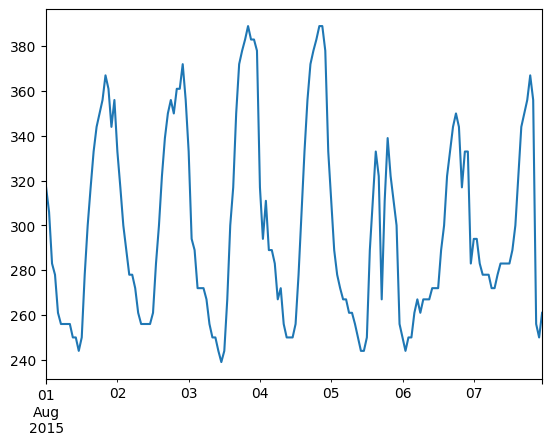

In [11]:
df2['Temp']['2015-08-01': '2015-08-07'].tz_localize('America/Chicago').plot()

### Checking ISD Meta Data is populated

In [ ]:
import os
from us_elec.SQL.sqldriver import ISDName

all_files = os.listdir('/tf/data/ISD')

wban_usaf_list = sqldr.get_data(
    f"SELECT USAF, WBAN, CALLSIGN FROM {ISDName.META}"
)


In [ ]:
expect_fn = isdm.get_isd_filenames()
get_fn = lambda x: x[0].split('/')[-1]
found_fn = [get_fn(x) for x in expect_fn]

In [ ]:
len(expect_fn)
len(all_files)

7570

# Profile Inserts

Naively start at around 1.2 bases uploaded per second.  Around 8 hours for full load in.
Sped up considerable using line_profiler to find hotspots.
- Eliminated using pandas to load in data.
- Restructured tables to use int rather than strings
- made string processing in python more efficient.


In [24]:
%load_ext line_profiler

In [25]:
from us_elec.SQL.sqldriver import format_insert_str

Originally:
53 sec
- had unique constraint.  
- around 80% time spent in insert.  50% of that in string formatting.
- Doing upsert (insert or update if time/station/value already present)
- Slow data load and filter using pandas

In [44]:
%lprun -u 0.01 -r \
       -f isdm.load_data \
       -f ISDDF.load_fwf_isd_file \
       -f ISDDF.get_cols \
        isdm.load_data(Nstation=50, bulk=True, update=False)

100%|██████████| 50/50 [00:16<00:00,  3.02it/s]


Timer unit: 0.01 s

Total time: 4.75408 s
File: /home/uselec_module/src/us_elec/SQL/sqldriver.py
Function: load_fwf_isd_file at line 108

Line #      Hits         Time  Per Hit   % Time  Line Contents
   108                                               @classmethod
   109                                               def load_fwf_isd_file(cls, filename: str) -> List[List]:
   110                                                   """Load ISD FWF datafile in directly.
   111                                                   Currently relying on space between entries.
   112                                                   """
   113        50          1.2      0.0      0.3          with gzip.open(filename, 'r') as gz:
   114        50         52.3      1.0     11.0              lines = gz.readlines()
   115        50        305.3      6.1     64.2              vals = [[cls.parse_val(x) for x in L.split()] for L in lines]
   116        50        116.6      2.3     24.5              out_

- around 40% spent in string processing for insert!
- should probably drop indexes, make them later. 
- dropped unique constraint
- around 3x faster to just parse in data directly rather than using pandas.
- Also faster to do bulk and only commit periodically.  

In [7]:
from us_elec.SQL.sqldriver import ISDDF

In [62]:
filename='/tf/data/ISD/722275-53843-2015.gz'

# Getting NDFD Data

## Historical Forecasts

The National Forecast Database saves day ahead forecasts (also at hourly resolution)
- https://www.ncei.noaa.gov/products/weather-climate-models/national-digital-forecast-database

- http access for recent data. 2018/06 - 2023 (present) 
    - 2018/2019 data in historical folder. 
    - There is a filelist.
- AIRS system - this gets every file that suits.  No parsing.
- S3 access 2020/06 to present.

YEUZ97 has coarser grid that YEUZ98.  Given goals, can use older, smaller data.

## Data after 2020/4

Recent data (2020/4 onwards) is available for all of NOAA from data stored on AWS:
https://registry.opendata.aws/noaa-ndfd/

An example of this data is here:
https://noaa-ndfd-pds.s3.amazonaws.com/wmo/temp/2020/04/16/YETZ98_KWBN_202004161748
What does the name mean?  Five digit code gives type of series, KWBN is location/grid?
Then date of forecast, with half-hourly updates.

From `data/NDFD/NDFDelem_fullres_202206.xls` example, CONUS hourly forecast data has 
- YEUZ87 for legacy 1-3 day forecast, YEUZ97 for current 1-3 day forecasts.  (That xls file is downloaded from the root of that bucket)

https://vlab.noaa.gov/web/mdl/ndfd

For an example on how to load that data into python, you can use Xarray.(Following https://docs.xarray.dev/en/stable/examples/ERA5-GRIB-example.html)
- Can load it in python using `xarray`.

In keeping with the scale of the project, we can use the CONUS forecast data (pass it through a CNN to condense down, then dense layers)

# Data from 2018/6 - 2020


In [3]:
import os

In [4]:
os.chdir('/tf/data/NDFD')

In [8]:
!tail -n10000 filelist.txt | grep YEUZ

./201006/20100618/YEUZ97_KWBN_201006181136
./201006/20100601/YEUZ98_KWBN_201006010851
./201006/20100601/YEUZ98_KWBN_201006011148
./201006/20100601/YEUZ98_KWBN_201006010449
./201006/20100601/YEUZ98_KWBN_201006012051
./201006/20100601/YEUZ97_KWBN_201006012140
./201006/20100601/YEUZ98_KWBN_201006011248
./201006/20100601/YEUZ98_KWBN_201006010747
./201006/20100601/YEUZ98_KWBN_201006010250
./201006/20100601/YEUZ98_KWBN_201006012349
./201006/20100601/YEUZ97_KWBN_201006011134
./201006/20100601/YEUZ98_KWBN_201006010349
./201006/20100601/YEUZ98_KWBN_201006011549
./201006/20100601/YEUZ97_KWBN_201006011735
./201006/20100601/YEUZ97_KWBN_201006010533
./201006/20100601/YEUZ98_KWBN_201006012248
./201006/20100601/YEUZ98_KWBN_201006011049
./201006/20100601/YEUZ98_KWBN_201006010948
./201006/20100601/YEUZ98_KWBN_201006010149
./201006/20100601/YEUZ98_KWBN_201006011948
./201006/20100601/YEUZ98_KWBN_201006011853
./201006/20100601/YEUZ98_KWBN_201006010548
./201006/20100601/YEUZ98_KWBN_201006011750
./201006/20

In [3]:
!pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 2.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 36.5 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 21.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
# get bucket file list

In [5]:
import boto3
bucket = 'noaa-ndfd-pds'
#Make sure you provide / in the end
prefix = 'wmo/temp/2020/04/16/'  

# start 2020/4/16

client = boto3.client('s3')
result = client.list_objects(Bucket=bucket, Prefix=prefix, Delimiter='/')
for o in result.get('CommonPrefixes'):
    print('sub folder : ', o.get('Prefix'))

NoCredentialsError: Unable to locate credentials